# Notebook to train a DNN for card play

### Libraries

We use the keras library for building, training and evaluating the network. A tutorial for keras can be found on (https://keras.io/) or https://www.tensorflow.org/guide/keras. There are different implementations of keras, here I will use the one build on tensorflow.


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt

Create dataframe with all the better than average player

In [2]:
df_stat = pd.read_json("data/stat/player_all_stat.json")
df_stat = df_stat.sort_values(by='mean', ascending=False)
mean = df_stat['mean'].mean()
df_stat = df_stat.drop(df_stat[df_stat['mean'] < mean].index)
df_stat.head()

,id,mean,std,nr
4563,30505,140.000000,0.000000,1
4476,78140,117.200000,39.448701,5
4540,50172,116.666667,35.803166,6
4485,9797,115.857143,35.324347,7
2988,51264,115.000000,35.853870,5


In [3]:
cards = [
    # Diamonds
    'DA', 'DK', 'DQ', 'DJ', 'D10', 'D9', 'D8', 'D7', 'D6',
    # Hearts
    'HA', 'HK', 'HQ', 'HJ', 'H10', 'H9', 'H8', 'H7', 'H6',
    # Spades
    'SA', 'SK', 'SQ', 'SJ', 'S10', 'S9', 'S8', 'S7', 'S6',
    # Clubs
    'CA', 'CK', 'CQ', 'CJ', 'C10', 'C9', 'C8', 'C7', 'C6'
]

forehand = ['FH']

user = ['user']
trump = ['trump']
cols = np.concatenate([cards,forehand,trump])
print(cols)
df = pd.DataFrame(columns=cols)

['DA' 'DK' 'DQ' 'DJ' 'D10' 'D9' 'D8' 'D7' 'D6' 'HA' 'HK' 'HQ' 'HJ' 'H10'
 'H9' 'H8' 'H7' 'H6' 'SA' 'SK' 'SQ' 'SJ' 'S10' 'S9' 'S8' 'S7' 'S6' 'CA'
 'CK' 'CQ' 'CJ' 'C10' 'C9' 'C8' 'C7' 'C6' 'FH' 'trump']


In [4]:
# import os
# from jass.logs.game_obs_action_log_entry import GameObsActionLogEntry
# import json
#
# for file in os.listdir('C:/dev/git/dl4g/notebooks/data/games/trump'):
#     with open("C:/dev/git/dl4g/notebooks/data/games/trump/"+file, "r") as file:
#         lines = file.readlines()
#
#         for line in lines:
#             line = json.loads(line.strip())
#             obs_log = GameObsActionLogEntry.from_json(line)
#
#             if obs_log.player_id in df_stat["id"]:
#                 row = np.concatenate([obs_log.obs.hand,[obs_log.obs.forehand],[obs_log.action]])
#                 df.loc[len(df.index)] =row
#
#
#
# df.head()

In [5]:
#df.to_pickle("trump_df.pkl") #read with
df = pd.read_pickle("trump_df.pkl")
print(df.shape)
print(df['trump'].value_counts())

(301521, 38)
10    113511
5      37107
2      33995
3      33622
4      30062
1      27048
0      26176
Name: trump, dtype: int64


In [6]:
df = df.sort_values(by='trump')
df.drop(df.tail(80_000).index, inplace = True)
df = df.sample(frac=1).reset_index(drop=True)
print(df.head())
print(df['trump'].value_counts())

  DA DK DQ DJ D10 D9 D8 D7 D6 HA  ... CK CQ CJ C10 C9 C8 C7 C6  FH trump
0  0  0  0  0   0  0  0  0  1  1  ...  0  0  0   1  0  1  0  1   0     2
1  1  1  0  0   0  0  0  1  0  0  ...  0  0  0   1  0  0  0  0   0     2
2  1  1  1  0   1  0  1  0  0  1  ...  0  0  0   0  1  0  0  0  -1     4
3  0  1  1  0   0  0  0  0  0  1  ...  0  0  1   0  0  1  0  0   0     1
4  1  0  0  0   1  0  0  1  1  1  ...  0  0  0   0  0  0  0  0   0     2

[5 rows x 38 columns]
5     37107
2     33995
3     33622
10    33511
4     30062
1     27048
0     26176
Name: trump, dtype: int64


In [7]:
df.trump = df.trump.astype('category')
df[cards + forehand] = df[cards + forehand].astype(bool)
df.trump.cat.rename_categories({10: 6}, inplace=True)

df.head()

df.trump.value_counts()
trump = df.pop('trump')
print(trump.unique())
y_train = tf.keras.utils.to_categorical(trump)

print(df.head())

[2, 4, 1, 3, 5, 0, 6]
Categories (7, int64): [2, 4, 1, 3, 5, 0, 6]
      DA     DK     DQ     DJ    D10     D9     D8     D7     D6     HA  ...  \
0  False  False  False  False  False  False  False  False   True   True  ...   
1   True   True  False  False  False  False  False   True  False  False  ...   
2   True   True   True  False   True  False   True  False  False   True  ...   
3  False   True   True  False  False  False  False  False  False   True  ...   
4   True  False  False  False   True  False  False   True   True   True  ...   

      CA     CK     CQ     CJ    C10     C9     C8     C7     C6     FH  
0  False  False  False  False   True  False   True  False   True  False  
1  False  False  False  False   True  False  False  False  False  False  
2  False  False  False  False  False   True  False  False  False   True  
3  False  False  False   True  False  False   True  False  False  False  
4  False  False  False  False  False  False  False  False  False  False  

[5 rows

In [22]:
from tensorflow.keras import regularizers
model = keras.Sequential()
model.add(keras.layers.Dense(37, activation='relu', input_shape=[37]))
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
# model.add(tf.keras.layers.Dropout(0.3)),
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))
model.add(keras.layers.Dense(300, activation="relu"
,kernel_regularizer=regularizers.l2(0.001)))

model.add(keras.layers.Dense(7, activation='softmax'))


lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=len(df)*1000,
  decay_rate=1,
  staircase=False)



model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              metrics=['accuracy'])

In [23]:
from keras.callbacks import EarlyStopping

print(df.shape)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(df.values, y_train, validation_split=0.25, epochs=80, batch_size=10_000
              #callbacks =[early_stop]
                    )

(221521, 37)
Epoch 1/80
17/17 [==============================] - 1s 47ms/step - loss: 3.6203 - accuracy: 0.2331 - val_loss: 3.1165 - val_accuracy: 0.3317
Epoch 2/80
17/17 [==============================] - 1s 36ms/step - loss: 2.7668 - accuracy: 0.4127 - val_loss: 2.4572 - val_accuracy: 0.4641
Epoch 3/80
17/17 [==============================] - 1s 37ms/step - loss: 2.2486 - accuracy: 0.5106 - val_loss: 2.0172 - val_accuracy: 0.5666
Epoch 4/80
17/17 [==============================] - 1s 37ms/step - loss: 1.8948 - accuracy: 0.5911 - val_loss: 1.7447 - val_accuracy: 0.6272
Epoch 5/80
17/17 [==============================] - 1s 37ms/step - loss: 1.6629 - accuracy: 0.6442 - val_loss: 1.5582 - val_accuracy: 0.6746
Epoch 6/80
17/17 [==============================] - 1s 37ms/step - loss: 1.5302 - accuracy: 0.6733 - val_loss: 1.4860 - val_accuracy: 0.6823
Epoch 7/80
17/17 [==============================] - 1s 36ms/step - loss: 1.4305 - accuracy: 0.6988 - val_loss: 1.3825 - val_accuracy: 0.7111


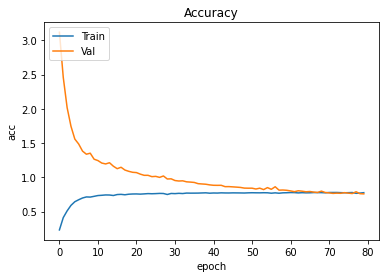

In [24]:


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train', 'Val'], loc='upper left')

In [25]:
model.save('models/v6')

INFO:tensorflow:Assets written to: models/v6\assets
